In [35]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from src.data import get_dataset
from src.features import get_preprocessor
from src.models import search_model


In [36]:
def print_score(m, *, X_train, y_train, X_valid, y_valid):
    res = {"r2_train": m.score(X_train, y_train), "r2_valid": m.score(X_valid, y_valid)}
    print(res)


def plot_importances(m, columns):
    importances = m.feature_importances_
    std = np.std([tree.feature_importances_ for tree in m], axis=0)

    forest_importances = pd.Series(importances, index=columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()


In [37]:
RAW_DATA_PATH = "../data/raw/olx_house_price_Q122.csv"
target = "price"


In [38]:
df = get_dataset(RAW_DATA_PATH)


In [39]:
df.dtypes

price                     float32
offer_type                 object
floor                     float32
area                      float32
rooms                        int8
offer_type_of_building     object
market                     object
longitude                 float32
latitude                  float32
city_name                  object
population                float32
voivodeship                object
dtype: object

In [40]:
X = df.drop(target, axis=1)
y = df[target]

preprocessor = get_preprocessor(df=X)
X = preprocessor.transform(X)

# reduce dataset size
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.80)
# split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.30)


In [41]:
preprocessor.get_feature_names_out()


array(['num__longitude', 'num__latitude', 'num__area', 'num__population',
       'ordinal__rooms', 'ordinal__offer_type',
       'ordinal__offer_type_of_building', 'ordinal__market',
       'ordinal__floor'], dtype=object)

In [42]:
model = search_model(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [43]:
model


TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_features=0.5,
                                                           min_samples_split=8,
                                                           n_estimators=90,
                                                           n_jobs=-1))

{'r2_train': 0.8434127537341813, 'r2_valid': 0.7123728155971594}


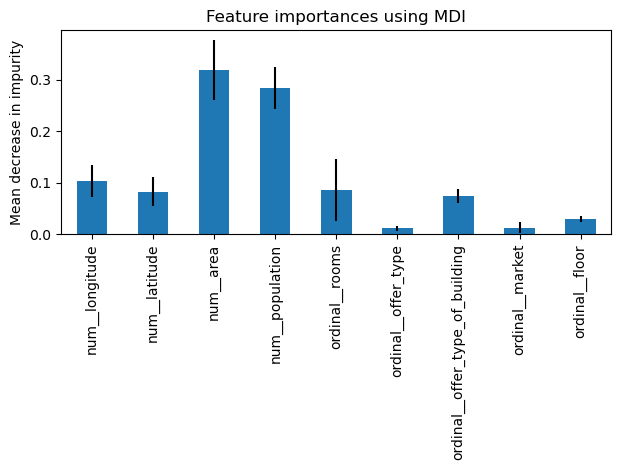

In [44]:
print_score(
    model,
    X_train=X_train,
    X_valid=X_valid,
    y_train=y_train,
    y_valid=y_valid,
)
plot_importances(model.regressor_, preprocessor.get_feature_names_out())


In [45]:
pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("model", model)])


In [46]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20
)


In [47]:
pipeline.score(X_valid, y_valid)


0.0021850469099033987

In [48]:
index = 5258

request = X_valid.iloc[index].to_dict()
true_price = y_valid.iloc[index]
request


{'offer_type': 'Private',
 'floor': 4.0,
 'area': 32.29999923706055,
 'rooms': 2,
 'offer_type_of_building': 'Housing Block',
 'market': 'aftermarket',
 'longitude': 18.755775451660156,
 'latitude': 53.487648010253906,
 'city_name': 'Grudziądz',
 'population': 97676.0,
 'voivodeship': 'Kuyavia-Pomerania'}

In [49]:
single_X = pd.DataFrame({k: [v] for k, v in request.items()})
print(f"predicted={pipeline.predict(single_X)[0]:.2f}, {true_price=}")


predicted=181937.67, true_price=154000.0


In [50]:
loaded_model = joblib.load("../models/2022-11-17_03:06:09.pkl")

In [51]:
print(f"predicted={loaded_model.predict(single_X)[0]:.2f}, {true_price=}")

predicted=161955.56, true_price=154000.0
